In [121]:
# Imports and configuration
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import plotly.graph_objects as go

print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(42)
np.random.seed(42)
plt.style.use("seaborn-v0_8")


PyTorch version: 2.5.1
Using device: cuda


In [122]:
# Load the CSV and basic checks
CSV_PATH = "../options_SPY_calls.csv"  # adjust if needed

df = pd.read_csv(CSV_PATH)
print("Loaded shape:", df.shape)
print(df.head())

required_cols = {"T", "K", "S0", "iv"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = df.dropna(subset=["T", "K", "S0", "iv"]).reset_index(drop=True)
df = df[df["T"] > 0.0].reset_index(drop=True)
S0 = float(df["S0"].iloc[0])

print("Final number of rows:", len(df))
print(f"Reference spot (first row) S0 = {S0:.4f}")
print(df[["T", "K", "S0", "iv"]].describe())


Loaded shape: (2725, 6)
       S0      K   C_mkt     T type   iv
0  667.84  570.0   93.78  0.01    C  0.0
1  667.84  575.0  102.28  0.01    C  0.0
2  667.84  580.0   85.62  0.01    C  0.0
3  667.84  590.0   75.65  0.01    C  0.0
4  667.84  600.0   76.35  0.01    C  0.0
Final number of rows: 2725
Reference spot (first row) S0 = 667.8400
                 T            K       S0           iv
count  2725.000000  2725.000000  2725.00  2725.000000
mean      0.407325   658.623119   667.84     0.222356
std       0.526181    69.045304     0.00     0.102312
min       0.010000   518.000000   667.84     0.000000
25%       0.060000   609.000000   667.84     0.160000
50%       0.210000   662.000000   667.84     0.210000
75%       0.590000   703.000000   667.84     0.270000
max       2.180000   815.000000   667.84     1.420000


In [123]:
# Prepare normalized features (T, K, S0) and the target iv
display_columns = ["T", "K", "S0", "iv"]
feature_cols = ["T", "K", "S0"]
target_col = "iv"

X_raw = df[feature_cols].values.astype(np.float32)
y_raw = df[[target_col]].values.astype(np.float32)

X_mean = X_raw.mean(axis=0, keepdims=True)
X_std = X_raw.std(axis=0, keepdims=True) + 1e-8
X_norm = (X_raw - X_mean) / X_std  # normalized features improve optimization stability

X_tensor = torch.from_numpy(X_norm)
y_tensor = torch.from_numpy(y_raw)

print(f"Feature tensor shape: {X_tensor.shape}")
print(f"Target tensor shape: {y_tensor.shape}")


Feature tensor shape: torch.Size([2725, 3])
Target tensor shape: torch.Size([2725, 1])


In [124]:
# Create Dataset and DataLoaders
class IvDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

full_dataset = IvDataset(X_tensor, y_tensor)
dataset_size = len(full_dataset)
if dataset_size < 2:
    train_size, val_size = dataset_size, 0
    train_dataset = full_dataset
    val_dataset = None
else:
    val_size = max(1, int(0.2 * dataset_size))
    train_size = dataset_size - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Train size: {train_size}, Val size: {val_size}")

batch_size = min(64, max(1, train_size)) if train_size > 0 else 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) if val_size > 0 else None


Train size: 2180, Val size: 545


In [125]:
# Define the neural network
class IvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)

model = IvNet().to(device)
print(model)


IvNet(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [126]:
# RMSE loss and optimizer
def rmse_loss(pred, target):
    mse = torch.mean((pred - target) ** 2)
    return torch.sqrt(mse + 1e-8)

optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [127]:
# Training loop
num_epochs = 200
history = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = rmse_loss(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_rmse = float(np.mean(train_losses)) if train_losses else float('nan')
    history["train"].append(train_rmse)

    model.eval()
    val_rmse = float('nan')
    if val_loader is not None:
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model(X_batch)
                val_loss = rmse_loss(preds, y_batch)
                val_losses.append(val_loss.item())
        val_rmse = float(np.mean(val_losses)) if val_losses else float('nan')
    history["val"].append(val_rmse)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d} | Train RMSE: {train_rmse:.6f} | Val RMSE: {val_rmse:.6f}")


Epoch    1 | Train RMSE: 0.114759 | Val RMSE: 0.081471
Epoch   10 | Train RMSE: 0.067140 | Val RMSE: 0.072000
Epoch   20 | Train RMSE: 0.065585 | Val RMSE: 0.072017
Epoch   30 | Train RMSE: 0.063971 | Val RMSE: 0.072908
Epoch   40 | Train RMSE: 0.064598 | Val RMSE: 0.073248
Epoch   50 | Train RMSE: 0.067002 | Val RMSE: 0.071080
Epoch   60 | Train RMSE: 0.062278 | Val RMSE: 0.071796
Epoch   70 | Train RMSE: 0.063367 | Val RMSE: 0.066312
Epoch   80 | Train RMSE: 0.062424 | Val RMSE: 0.068789
Epoch   90 | Train RMSE: 0.060717 | Val RMSE: 0.070993
Epoch  100 | Train RMSE: 0.061223 | Val RMSE: 0.065639
Epoch  110 | Train RMSE: 0.059430 | Val RMSE: 0.067202
Epoch  120 | Train RMSE: 0.061090 | Val RMSE: 0.070935
Epoch  130 | Train RMSE: 0.059281 | Val RMSE: 0.066091
Epoch  140 | Train RMSE: 0.059568 | Val RMSE: 0.064771
Epoch  150 | Train RMSE: 0.059198 | Val RMSE: 0.064021
Epoch  160 | Train RMSE: 0.059790 | Val RMSE: 0.067675
Epoch  170 | Train RMSE: 0.058545 | Val RMSE: 0.067400
Epoch  180

Final RMSE on full dataset (iv): 0.066493


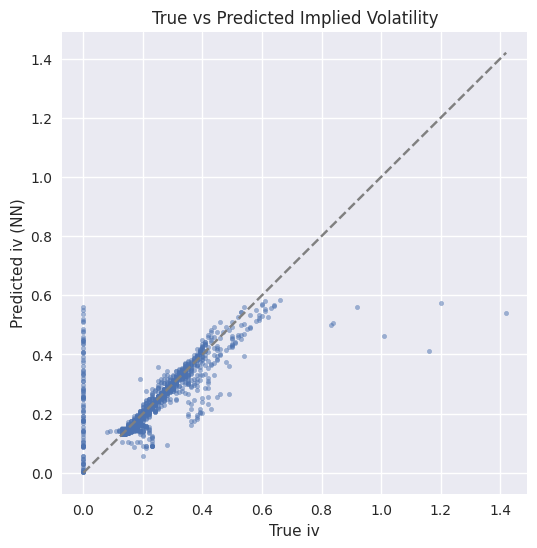

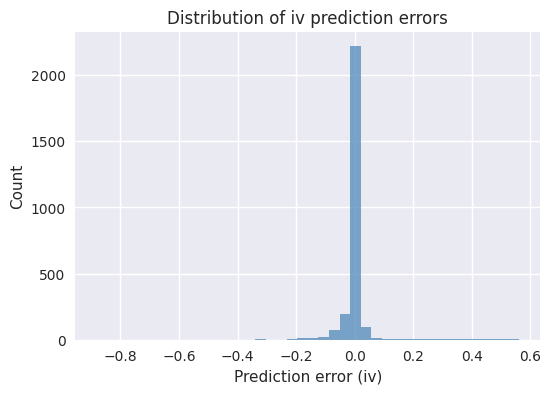

In [128]:
# Evaluation and diagnostics
model.eval()
with torch.no_grad():
    X_full = X_tensor.to(device)
    y_full = y_tensor.to(device)
    y_pred = model(X_full).cpu().numpy().flatten()
    y_true = y_full.cpu().numpy().flatten()

final_rmse = math.sqrt(np.mean((y_pred - y_true) ** 2))
print(f"Final RMSE on full dataset (iv): {final_rmse:.6f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=10)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, linestyle="--", color="gray")
plt.xlabel("True iv")
plt.ylabel("Predicted iv (NN)")
plt.title("True vs Predicted Implied Volatility")
plt.grid(True)
plt.show()

errors = y_pred - y_true
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=40, alpha=0.7, color="steelblue")
plt.xlabel("Prediction error (iv)")
plt.ylabel("Count")
plt.title("Distribution of iv prediction errors")
plt.grid(True)
plt.show()


In [129]:
# Plotly 3D surface driven by the neural network implied volatilities
S0_ref = float(df['S0'].median())
K_min, K_max = df['K'].min(), df['K'].max()
T_min, T_max = 0.1, df['T'].max()
K_vals = np.linspace(K_min, K_max, 200)
T_vals = np.linspace(T_min, T_max, 200)
KK, TT = np.meshgrid(K_vals, T_vals)

grid_raw = np.column_stack([
    TT.ravel().astype(np.float32),
    KK.ravel().astype(np.float32),
    np.full(TT.size, S0_ref, dtype=np.float32),
])
grid_norm = (grid_raw - X_mean) / X_std
grid_tensor = torch.from_numpy(grid_norm).to(device)

model.eval()
with torch.no_grad():
    grid_iv = model(grid_tensor).cpu().numpy().reshape(TT.shape)

IV_surface_NN = grid_iv
fig = go.Figure(data=[go.Surface(x=KK, y=TT, z=IV_surface_NN, colorscale='Plasma', opacity=0.85)])
fig.update_layout(
    title='Neural Network Implied Volatility Surface',
    scene=dict(
        xaxis_title='Strike Price',
        yaxis_title='Time to Maturity (Years)',
        zaxis_title='Implied Volatility (NN)'
    ),
    template='plotly_dark',
    width=900,
    height=600
)
fig.show()


